Notebook Color Scheme:


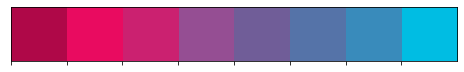

In [4]:
# Libraries
import os
import gc
import wandb
import time
import random
import math
import glob
from scipy import spatial
from tqdm import tqdm
import warnings
import cv2
import pandas as pd
import numpy as np
from numpy import dot, sqrt
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from IPython.display import display_html
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import torch
import torch.nn as nn
plt.rcParams.update({'font.size': 16})

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'HandM', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[95m'
    E = '\033[0m'
    
my_colors = ["#AF0848", "#E90B60", "#CB2170", "#954E93", "#705D98", "#5573A8", "#398BBB", "#00BDE3"]
print(clr.S+"Notebook Color Scheme:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

# bk_image = plt.imread("../input/hm-fashion-recommender-dataset/background.jpg")

In [5]:
!wandb login 83f2cd95fe04f4864bd51515cdc0bf7a450d94a3

In [7]:
def insert_image(path, zoom, xybox, ax):
    '''Insert an image within matplotlib'''
    imagebox = OffsetImage(mpimg.imread(path), zoom=zoom)
    ab = AnnotationBbox(imagebox, xy=(0.5, 0.7), frameon=False, pad=1, xybox=xybox)
    ax.add_artist(ab)
    
    
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


# === 🐝 W&B ===
def save_dataset_artifact(run_name, artifact_name, path):
    '''Saves dataset to W&B Artifactory.
    run_name: name of the experiment
    artifact_name: under what name should the dataset be stored
    path: path to the dataset'''
    
    run = wandb.init(project='HandM', 
                     name=run_name, 
                     config=CONFIG)
    artifact = wandb.Artifact(name=artifact_name, 
                              type='dataset')
    artifact.add_file(path)

    wandb.log_artifact(artifact)
    wandb.finish()
    print("Artifact has been saved successfully.")
    
    
def create_wandb_plot(x_data=None, y_data=None, x_name=None, y_name=None, title=None, log=None, plot="line"):
    '''Create and save lineplot/barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    data = [[label, val] for (label, val) in zip(x_data, y_data)]
    table = wandb.Table(data=data, columns = [x_name, y_name])
    
    if plot == "line":
        wandb.log({log : wandb.plot.line(table, x_name, y_name, title=title)})
    elif plot == "bar":
        wandb.log({log : wandb.plot.bar(table, x_name, y_name, title=title)})
    elif plot == "scatter":
        wandb.log({log : wandb.plot.scatter(table, x_name, y_name, title=title)})
        
        
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None):
    '''Create and save histogram in W&B Environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title=title)})
    
    
# 🐝 Log Cover Photo
run = wandb.init(project='HandM', name='CoverPhoto', config=CONFIG)
cover = plt.imread("../input/hm-fashion-recommender-dataset/pics/Kaggle Covers.png")
wandb.log({"example": wandb.Image(cover)})
wandb.finish()

In [8]:
%%time

# Read in the data
articles = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")
customers = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")
ss = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv")

CPU times: total: 22.6 s
Wall time: 47 s


In [9]:
print(clr.S+"ARTICLES:"+clr.E, articles.shape)
display_html(articles.head(3))
print("\n", clr.S+"CUSTOMERS:"+clr.E, customers.shape)
display_html(customers.head(3))
print("\n", clr.S+"TRANSACTIONS:"+clr.E, transactions.shape)
display_html(transactions.head(3))
print("\n", clr.S+"SAMPLE_SUBMISSION:"+clr.E, ss.shape)
display_html(ss.head(3))

ARTICLES: (105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.



 CUSTOMERS: (1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...



 TRANSACTIONS: (31788324, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2



 SAMPLE_SUBMISSION: (1371980, 2)


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...


In [10]:
# 🐝 W&B Experiment
run = wandb.init(project='HandM', name='Articles', config=CONFIG)

In [11]:
def adjust_id(x):
    '''Adjusts article ID code.'''
    x = str(x)
    if len(x) == 9:
        x = "0"+x
    
    return x

In [12]:
print(clr.S+"There are no missing values in any columns but 'Detail Description':"+clr.E,
        articles.isna().sum()[-1], "total missing values")

# Replace missing values
articles.fillna(value="No Description", inplace=True)

# Adjust the article ID and product code to be string & add "0"
articles["article_id"] = articles["article_id"].apply(lambda x: adjust_id(x))
articles["product_code"] = articles["article_id"].apply(lambda x: x[:3])

There are no missing values in any columns but 'Detail Description': 416 total missing values


In [34]:
# Get all paths from the image folder
all_image_paths = glob.glob(f"../input/h-and-m-personalized-fashion-recommendations/images/*/*")

print(clr.S+"Number of unique article_ids within articles.csv:"+clr.E, len(articles), "\n"+
      clr.S+"Number of unique images within the image folder:"+clr.E, len(all_image_paths), "\n"+
      clr.S+"=> not all article_ids have a corresponding image!!!"+clr.E, "\n")

# 🐝 Log Distinct article IDs
wandb.log({"article_ids":len(articles)})

# Get all valid article ids
# Create a set() - as it moves faster than a list
all_image_ids = set()

for path in tqdm(all_image_paths):
    article_id = path.split('\\')[-1].split('.')[0]
    all_image_ids.add(article_id)

Number of unique article_ids within articles.csv: 105542 
Number of unique images within the image folder: 105100 
=> not all article_ids have a corresponding image!!! 



100%|██████████| 105100/105100 [00:00<00:00, 1449526.66it/s]


In [37]:
# An image path example: ../input/h-and-m-personalized-fashion-recommendations/images/010/0108775015.jpg

# Create full path to the article image
images_path = "../input/h-and-m-personalized-fashion-recommendations/images/"
articles["path"] = images_path + articles["product_code"] + "/" + articles["article_id"] + ".jpg"

# Adjust the incorrect paths and set them to None
for k, article_id in tqdm(enumerate(articles["article_id"])):
    if article_id not in all_image_ids:
        articles.loc[k, "path"] = None

105542it [00:00, 1529535.94it/s]


Total Number of unique Product Names: 45875


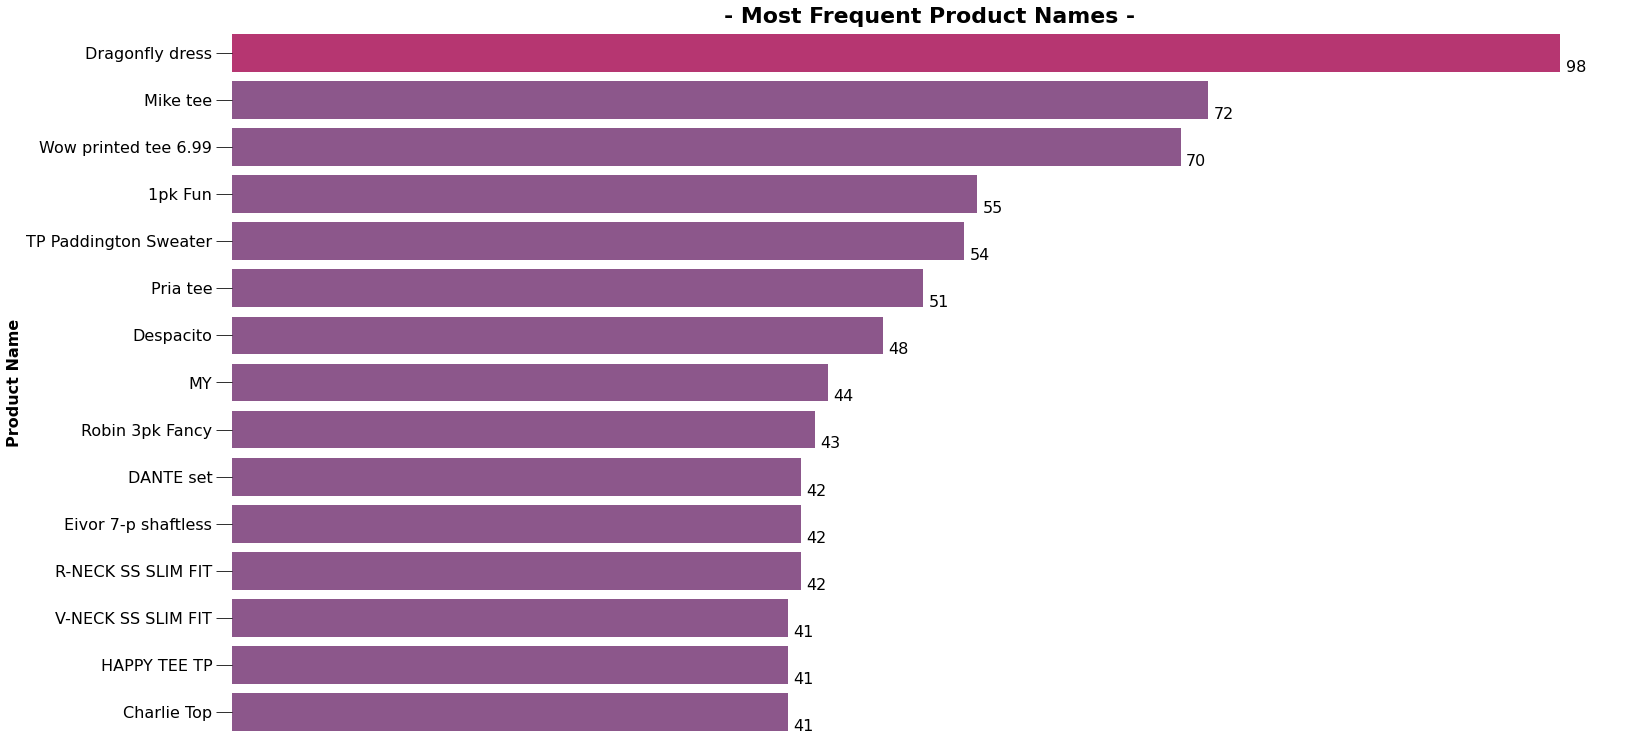

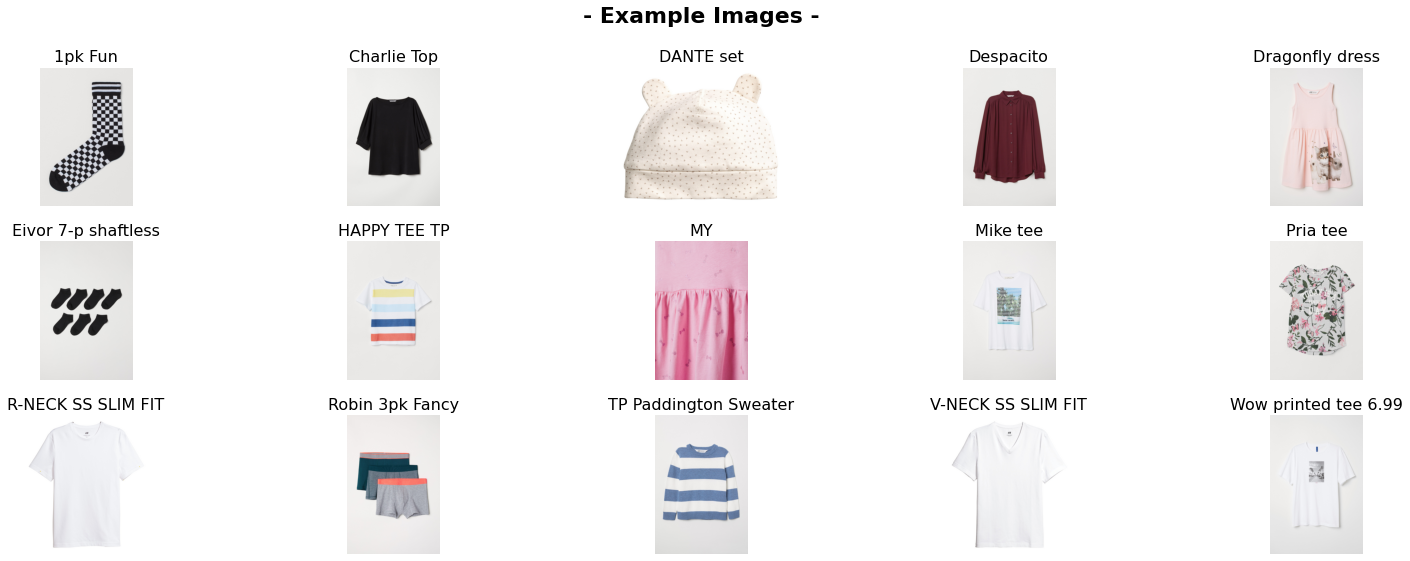

In [39]:
print(clr.S+"Total Number of unique Product Names:"+clr.E, articles["prod_name"].nunique())

# Data
prod_name = articles["prod_name"].value_counts().reset_index().head(15)
total_prod_names = articles["prod_name"].nunique()
clrs = ["#CB2170" if x==max(prod_name["prod_name"]) else '#954E93' for x in prod_name["prod_name"]]

# Get images
prod_name_images = articles[articles["prod_name"].isin(prod_name["index"].tolist())].groupby("prod_name")["path"].first().reset_index()
image_paths = prod_name_images["path"].tolist()
image_names = prod_name_images["prod_name"].tolist()

# Plot
fig, ax = plt.subplots(figsize=(25, 13))
plt.title('- Most Frequent Product Names -', size=22, weight="bold")

sns.barplot(data=prod_name, x="prod_name", y="index", ax=ax,
            palette=clrs)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
# plt.imshow(bk_image, zorder=0, extent=[x0, x1, y0, y1], alpha=0.35, aspect='auto')

show_values_on_bars(axs=ax, h_v="h", space=0.4)
plt.ylabel("Product Name", size = 16, weight="bold")
plt.xlabel("")
plt.xticks([])
plt.yticks(size=16)
plt.tick_params(size=16)

# insert_image(path='../input/hm-fashion-recommender-dataset/pics/dragonfly.jpg', zoom=0.45, xybox=(92, 11), ax=ax)

sns.despine(left=True, bottom=True)
plt.show();

print("\n")

# Plot
fig, axs = plt.subplots(3, 5, figsize=(23, 8))
fig.suptitle('- Example Images -', size=22, weight="bold")
axs = axs.flatten()

for k, (path, name) in enumerate(zip(image_paths, image_names)):
    axs[k].set_title(f"{name}", size = 16)
    img = plt.imread(path)
    axs[k].imshow(img)
    axs[k].axis("off")

plt.tight_layout()
plt.show()

In [40]:
# 🐝 Log Barplot to W&B
create_wandb_plot(x_data=prod_name["index"], y_data=prod_name["prod_name"],
                  x_name="Product Name", y_name="Frequency", 
                  title="- Most Frequent Product Names -", log="prod_name", plot="bar")

Total Number of unique Product Types: 131


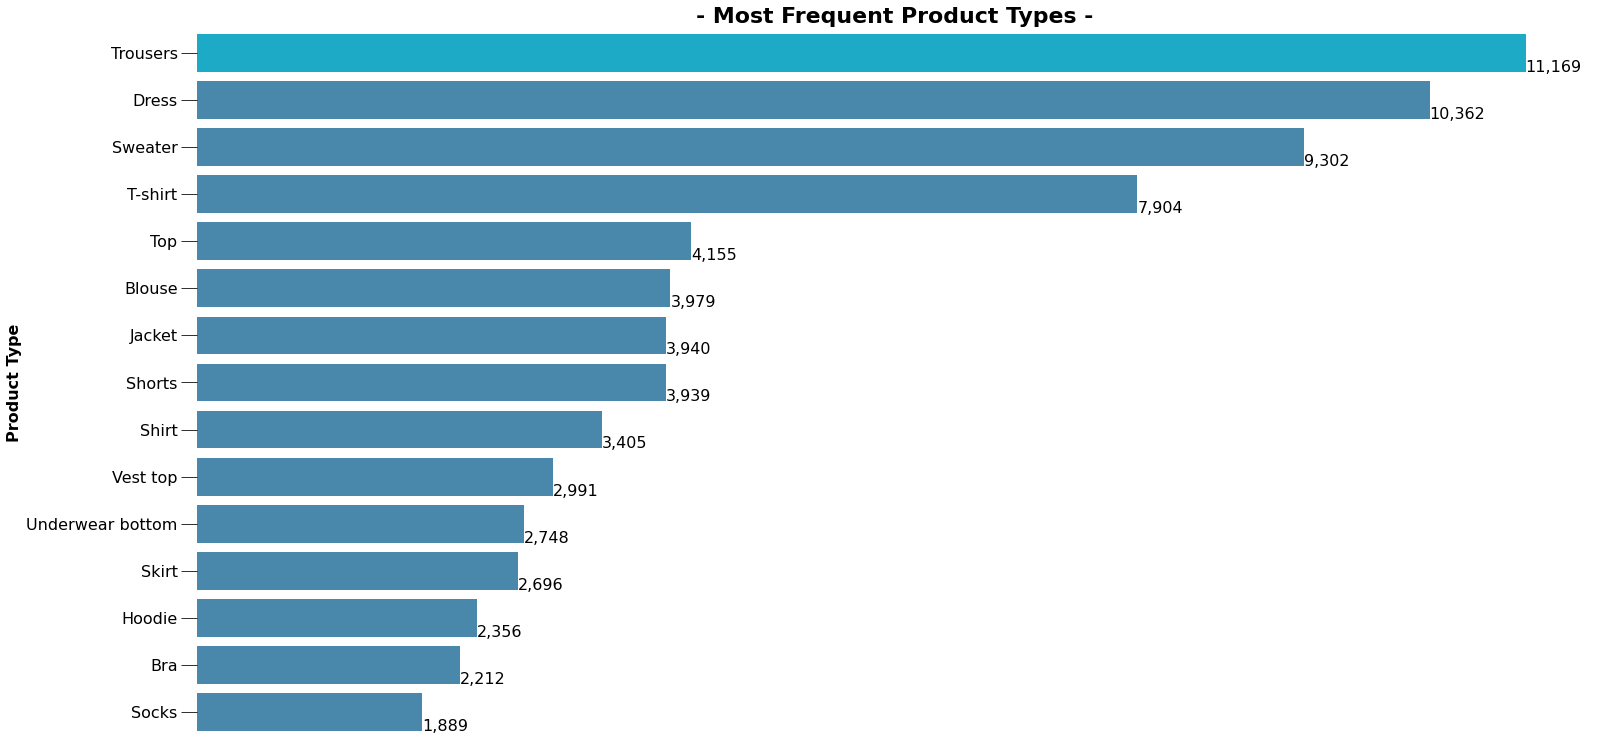

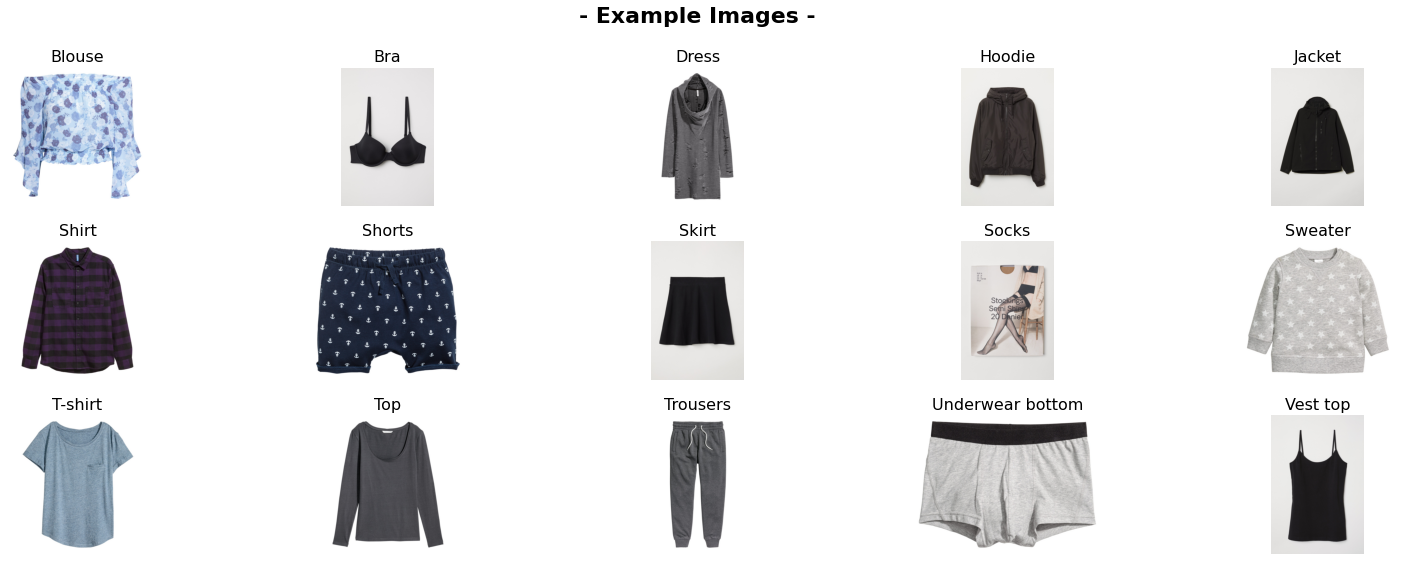

In [41]:
print(clr.S+"Total Number of unique Product Types:"+clr.E, articles["product_type_name"].nunique())

# Data
prod_type = articles["product_type_name"].value_counts().reset_index().head(15)
total_prod_types = articles["product_type_name"].nunique()
clrs = ["#00BDE3" if x==max(prod_type["product_type_name"]) else '#398BBB' for x in prod_type["product_type_name"]]

# Get images
prod_type_images = articles[articles["product_type_name"].isin(prod_type["index"].tolist())].groupby("product_type_name")["path"].first().reset_index()
image_paths = prod_type_images["path"].tolist()
image_names = prod_type_images["product_type_name"].tolist()

# Plot
fig, ax = plt.subplots(figsize=(25, 13))
plt.title('- Most Frequent Product Types -', size=22, weight="bold")

sns.barplot(data=prod_type, x="product_type_name", y="index", ax=ax,
            palette=clrs)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
# plt.imshow(bk_image, zorder=0, extent=[x0, x1, y0, y1], alpha=0.35, aspect='auto')

show_values_on_bars(axs=ax, h_v="h", space=0.4)
plt.ylabel("Product Type", size = 16, weight="bold")
plt.xlabel("")
plt.xticks([])
plt.yticks(size=16)
plt.tick_params(size=16)

# insert_image(path='../input/hm-fashion-recommender-dataset/pics/blue.jpg', zoom=0.45, xybox=(11000, 11), ax=ax)

sns.despine(left=True, bottom=True)
plt.show();

print("\n")

# Plot
fig, axs = plt.subplots(3, 5, figsize=(23, 8))
fig.suptitle('- Example Images -', size=22, weight="bold")
axs = axs.flatten()

for k, (path, name) in enumerate(zip(image_paths, image_names)):
    axs[k].set_title(f"{name}", size = 16)
    img = plt.imread(path)
    axs[k].imshow(img)
    axs[k].axis("off")

plt.tight_layout()
plt.show()

In [42]:
# 🐝 Log Barplot to W&B
create_wandb_plot(x_data=prod_type["index"], y_data=prod_type["product_type_name"],
                  x_name="Product Type", y_name="Frequency", 
                  title="- Most Frequent Product Types -", log="prod_type", plot="bar")

Total Number of unique Product Group: 19


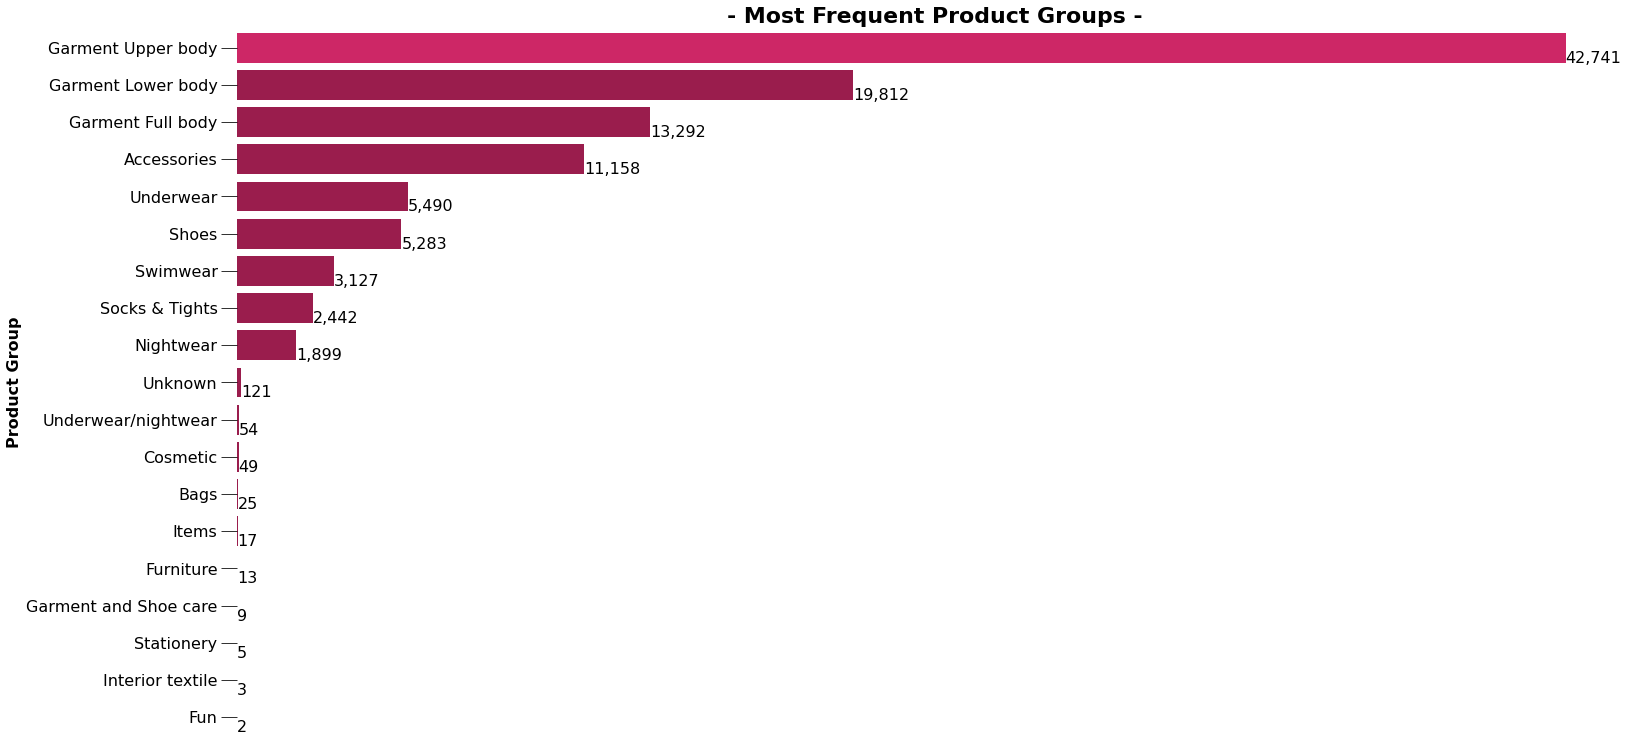

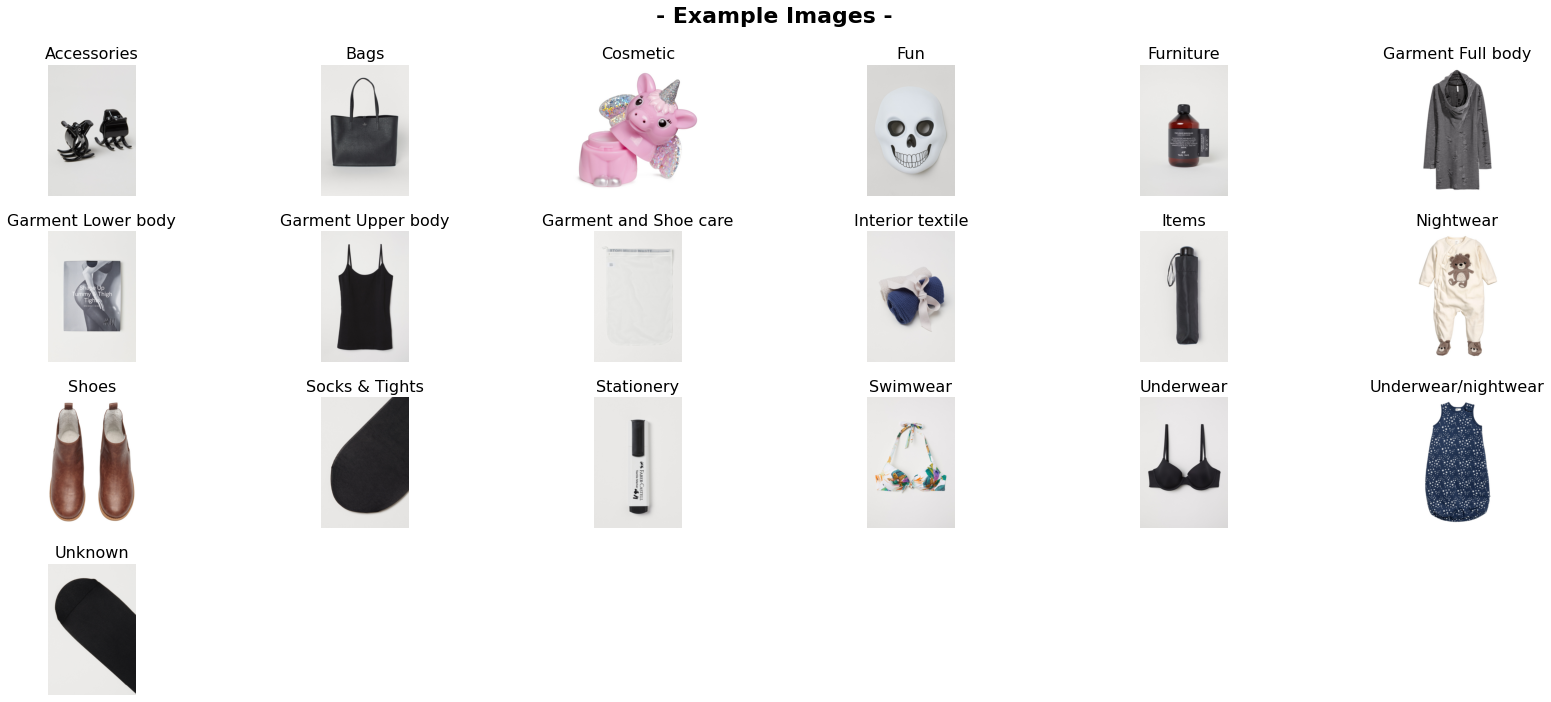

In [43]:
print(clr.S+"Total Number of unique Product Group:"+clr.E, articles["product_group_name"].nunique())

# Data
prod_group = articles["product_group_name"].value_counts().reset_index()
total_prod_groups = articles["product_group_name"].nunique()
clrs = ["#E90B60" if x==max(prod_group["product_group_name"]) else '#AF0848' for x in prod_group["product_group_name"]]

# Get images
prod_group_images = articles[articles["product_group_name"].isin(prod_group["index"].tolist())].groupby("product_group_name")["path"].first().reset_index()
image_paths = prod_group_images["path"].tolist()
image_names = prod_group_images["product_group_name"].tolist()

# Plot
fig, ax = plt.subplots(figsize=(25, 13))
plt.title('- Most Frequent Product Groups -', size=22, weight="bold")

sns.barplot(data=prod_group, x="product_group_name", y="index", ax=ax,
            palette=clrs)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
# plt.imshow(bk_image, zorder=0, extent=[x0, x1, y0, y1], alpha=0.35, aspect='auto')

show_values_on_bars(axs=ax, h_v="h", space=0.4)
plt.ylabel("Product Group", size = 16, weight="bold")
plt.xlabel("")
plt.xticks([])
plt.yticks(size=16)
plt.tick_params(size=16)

# insert_image(path='../input/hm-fashion-recommender-dataset/pics/chloe.jpg', zoom=0.45, xybox=(40000, 14), ax=ax)

sns.despine(left=True, bottom=True)
plt.show();

print("\n")

# Plot
fig, axs = plt.subplots(4, 6, figsize=(23, 10))
fig.suptitle('- Example Images -', size=22, weight="bold")
axs = axs.flatten()

for k, (path, name) in enumerate(zip(image_paths, image_names)):
    axs[k].set_title(f"{name}", size = 16)
    img = plt.imread(path)
    axs[k].imshow(img)
    axs[k].axis("off")

for a in [-1, -2, -3, -4, -5]: axs[a].set_visible(False)
plt.tight_layout()
plt.show()

In [44]:
# 🐝 Log Barplot to W&B
create_wandb_plot(x_data=prod_group["index"], y_data=prod_group["product_group_name"],
                  x_name="Product Group", y_name="Frequency", 
                  title="- Most Frequent Product Group -", log="prod_group", plot="bar")

In [45]:
def change_color(x):
    '''Change color name.'''
    if ("light" in x.lower().strip()) or \
        ("dark" in x.lower().strip()) or \
        ("greyish" in x.lower().strip()) or \
        ("yellowish" in x.lower().strip()) or \
        ("greenish" in x.lower().strip()) or \
        ("off" in x.lower().strip()) or \
        ("other" in x.lower().strip()):
        x = x.split(" ")[-1]
        
    return x

articles["colour_group_name"] = articles["colour_group_name"].apply(lambda x: change_color(x))

Total Number of unique Product Appearances: 30
Total Number of unique Product Colors (after preprocess): 20


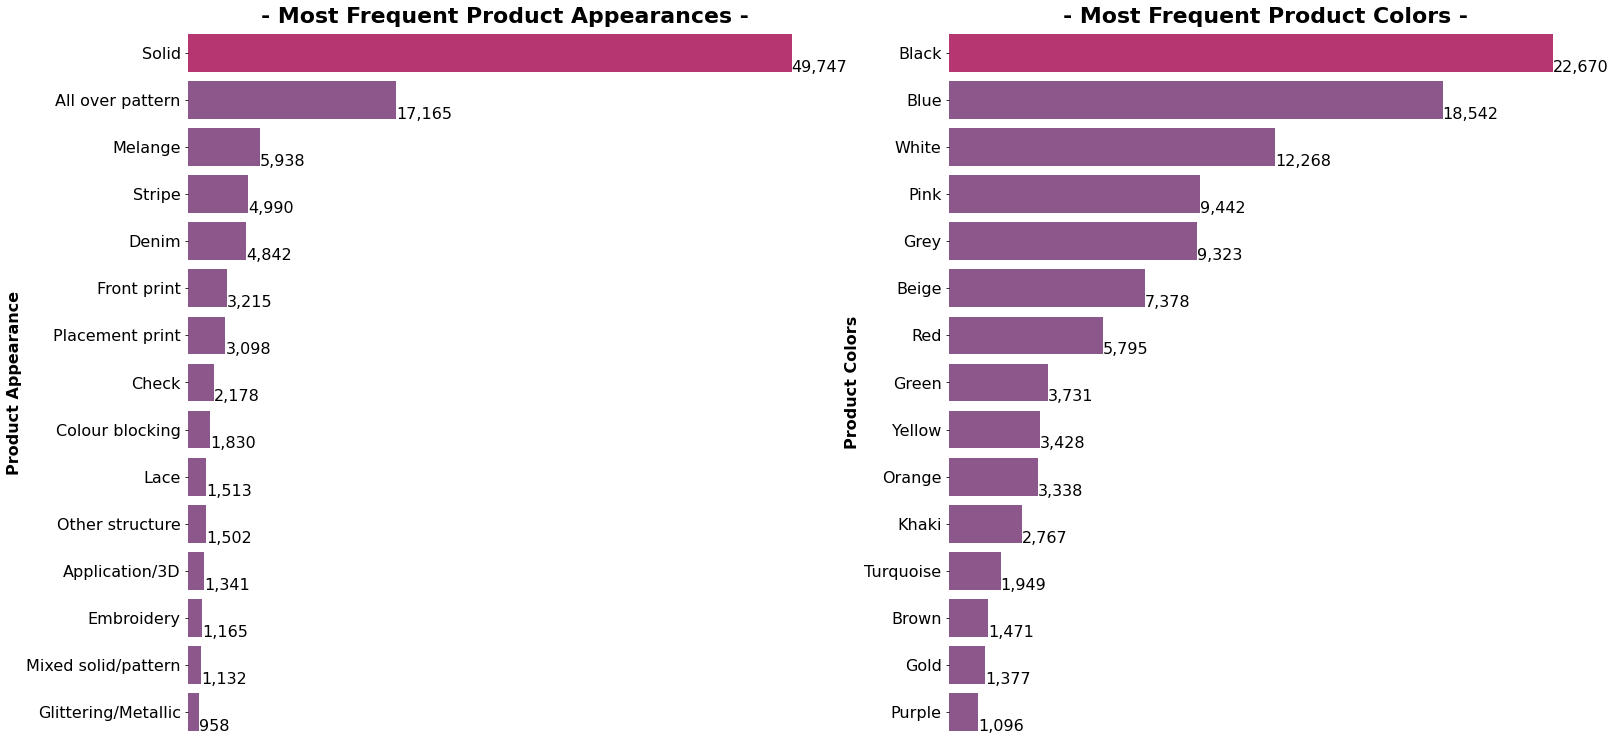

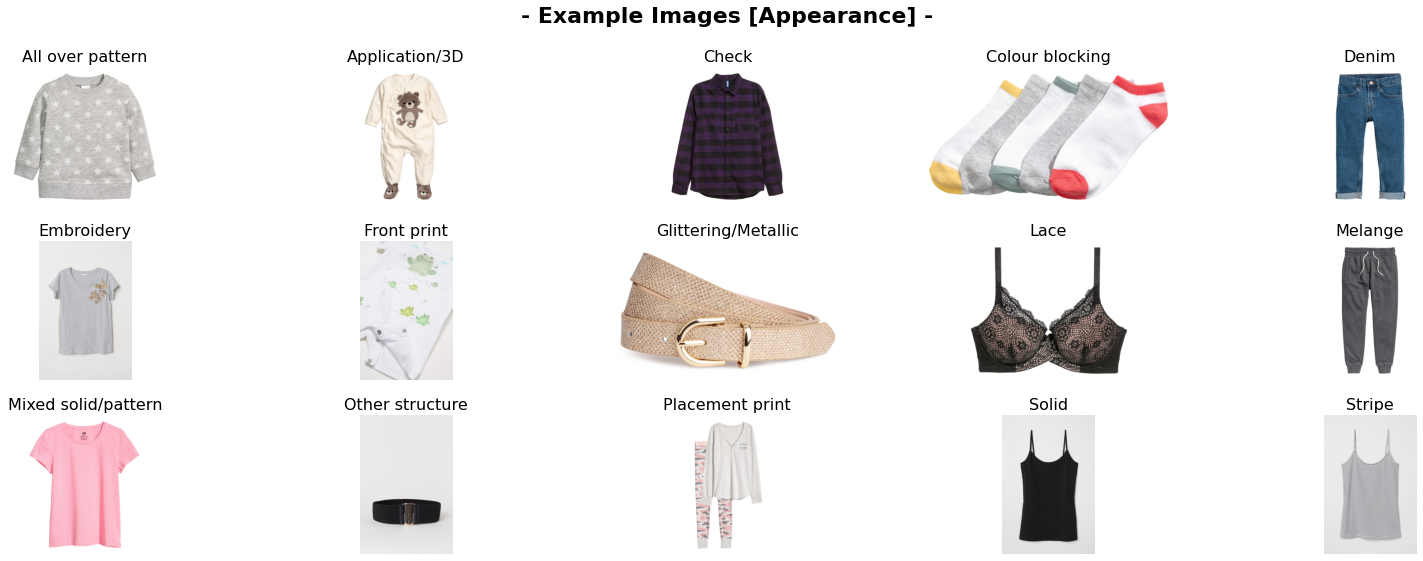

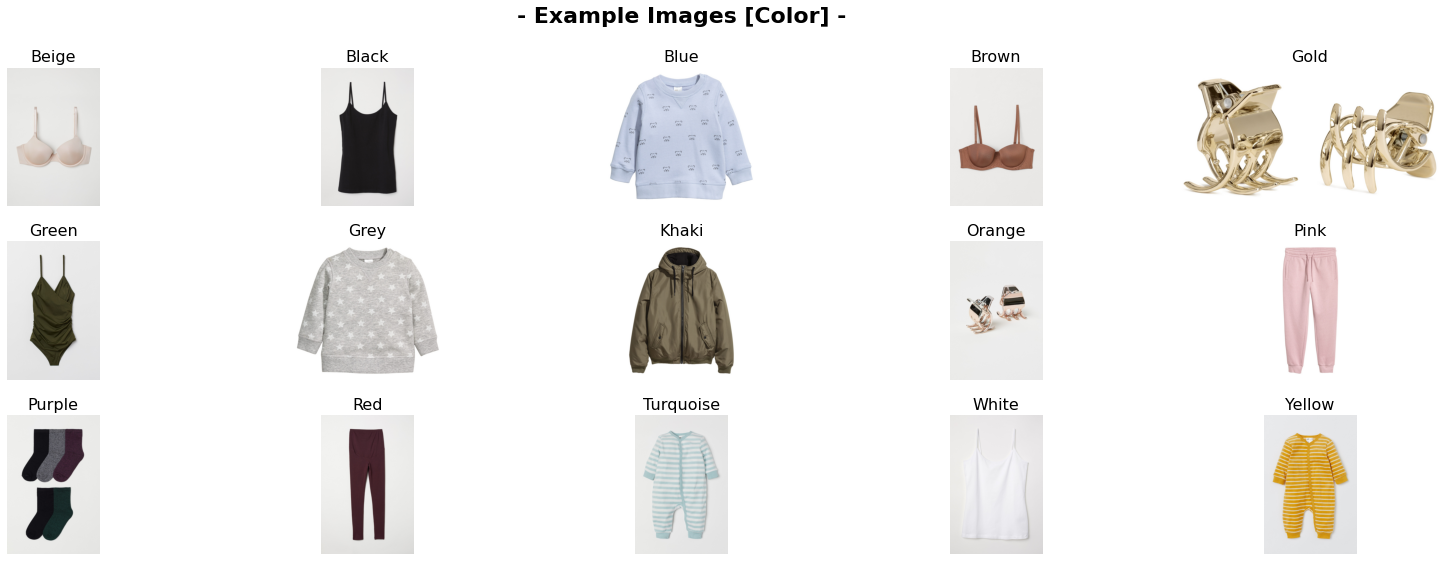

In [46]:
# Appearance and color
print(clr.S+"Total Number of unique Product Appearances:"+clr.E, articles["graphical_appearance_name"].nunique())
print(clr.S+"Total Number of unique Product Colors (after preprocess):"+clr.E, articles["colour_group_name"].nunique())

# --- Data 1 ---
prod_appearance = articles["graphical_appearance_name"].value_counts().reset_index().head(15)
total_prod_appearances = articles["graphical_appearance_name"].nunique()
clrs1 = ["#AF0848" if x==max(prod_appearance["graphical_appearance_name"]) else '#E90B60' for x in prod_appearance["graphical_appearance_name"]]


# Get images
prod_appearance_images = articles[articles["graphical_appearance_name"].isin(prod_appearance["index"].tolist())].groupby("graphical_appearance_name")["path"].first().reset_index()
image_paths1 = prod_appearance_images["path"].tolist()
image_names1 = prod_appearance_images["graphical_appearance_name"].tolist()

# --- Data 2 ---
prod_color = articles["colour_group_name"].value_counts().reset_index().head(15)
total_prod_color = articles["colour_group_name"].nunique()
clrs2 = ["#CB2170" if x==max(prod_color["colour_group_name"]) else '#954E93' for x in prod_color["colour_group_name"]]

# Get images
prod_color_images = articles[articles["colour_group_name"].isin(prod_color["index"].tolist())].groupby("colour_group_name")["path"].first().reset_index()
image_paths2 = prod_color_images["path"].tolist()
image_names2 = prod_color_images["colour_group_name"].tolist()

# Plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 13))

ax1.set_title('- Most Frequent Product Appearances -', size=22, weight="bold")
sns.barplot(data=prod_appearance, x="graphical_appearance_name", y="index", ax=ax1,
            palette=clrs2)
x0,x1 = ax1.get_xlim()
y0,y1 = ax1.get_ylim()
# ax1.imshow(bk_image, zorder=0, extent=[x0, x1, y0, y1], alpha=0.35, aspect='auto')

show_values_on_bars(axs=ax1, h_v="h", space=0.4)
ax1.set_ylabel("Product Appearance", size = 16, weight="bold")
ax1.set_xlabel("")
ax1.set_xticks([])
# ax1.set_yticks(size=16)
# ax1.set_tick_params(size=16)

# insert_image(path='../input/hm-fashion-recommender-dataset/pics/blue.jpg', zoom=0.45, xybox=(11000, 11), ax=ax1)


ax2.set_title('- Most Frequent Product Colors -', size=22, weight="bold")
sns.barplot(data=prod_color, x="colour_group_name", y="index", ax=ax2,
            palette=clrs2)
x0,x1 = ax2.get_xlim()
y0,y1 = ax2.get_ylim()
# ax2.imshow(bk_image, zorder=0, extent=[x0, x1, y0, y1], alpha=0.35, aspect='auto')

show_values_on_bars(axs=ax2, h_v="h", space=0.4)
ax2.set_ylabel("Product Colors", size = 16, weight="bold")
ax2.set_xlabel("")
ax2.set_xticks([])
# ax1.set_yticks(size=16)
# ax1.set_tick_params(size=16)

# insert_image(path='../input/hm-fashion-recommender-dataset/pics/blue.jpg', zoom=0.45, xybox=(11000, 11), ax=ax1)

sns.despine(left=True, bottom=True)
plt.show();

print("\n")

# Plot
fig, axs = plt.subplots(3, 5, figsize=(23, 8))
fig.suptitle('- Example Images [Appearance] -', size=22, weight="bold")
axs = axs.flatten()

for k, (path, name) in enumerate(zip(image_paths1, image_names1)):
    axs[k].set_title(f"{name}", size = 16)
    img = plt.imread(path)
    axs[k].imshow(img)
    axs[k].axis("off")

plt.tight_layout()
plt.show()

# Plot
fig, axs = plt.subplots(3, 5, figsize=(23, 8))
fig.suptitle('- Example Images [Color] -', size=22, weight="bold")
axs = axs.flatten()

for k, (path, name) in enumerate(zip(image_paths2, image_names2)):
    axs[k].set_title(f"{name}", size = 16)
    img = plt.imread(path)
    axs[k].imshow(img)
    axs[k].axis("off")

plt.tight_layout()
plt.show()

In [47]:
# 🐝 Log Barplot to W&B
create_wandb_plot(x_data= prod_appearance["index"], y_data=prod_appearance["graphical_appearance_name"],
                  x_name="Product Appearance", y_name="Frequency", 
                  title="- Most Frequent Product Appearance -", log="prod_appearance", plot="bar")

create_wandb_plot(x_data= prod_color["index"], y_data=prod_color["colour_group_name"],
                  x_name="Product Color", y_name="Frequency", 
                  title="- Most Frequent Product Color -", log="prod_color", plot="bar")

In [48]:
def similar_color_func(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    '''Creates a custom function for the color of the wordcloud.'''
    
    h = 270 # 0 - 360 <- the color hue
    s = 40 # 0-100 <- the color saturation
    l = random_state.randint(30, 70) # 0 - 100 <- gradient
    
    return "hsl({}, {}%, {}%)".format(h, s, l)

Total Number of unique Article Descriptions: 43405 



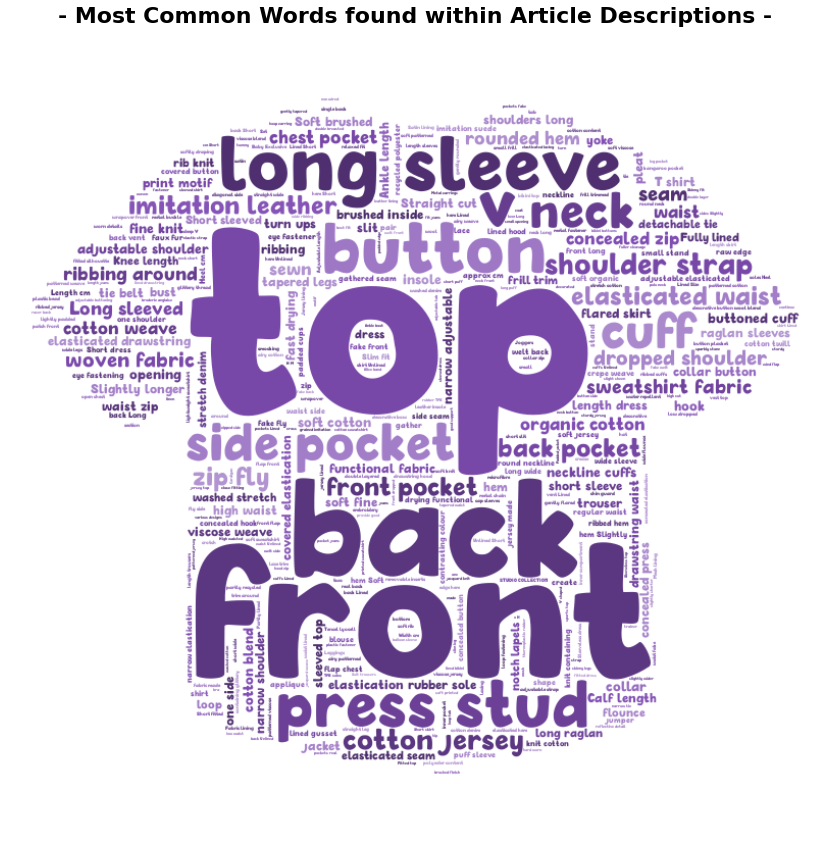

In [50]:
print(clr.S+"Total Number of unique Article Descriptions:"+clr.E, articles["detail_desc"].nunique(), "\n")

# Get descriptions and convert them to a string
text = articles["detail_desc"].unique()
text = " ".join(text)

# Get the mask - the form of the wordcloud
mask = np.array(Image.open('../input/hm-fashion-recommender-dataset/pics/mask.jpg'))

# Create wordcloud object
wc = WordCloud(mask=mask, background_color="white", max_words=2000,
               stopwords=STOPWORDS, max_font_size=256,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0], font_path="../input/hm-fashion-recommender-dataset/MorningRainbow.ttf",
               color_func=similar_color_func)
wc.generate(text)

# Plot
fig = plt.figure(figsize=(15, 15))
plt.title("- Most Common Words found within Article Descriptions -",
           size=22, weight="bold")
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

In [51]:
# 🐝 Save wordcloud to Dashboard
fig.canvas.draw()
image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))

wandb.log({"wordcloud": wandb.Image(image_from_plot)})

wandb.finish()

In [58]:
# 🐝 Save the updated `articles` file.
articles.to_parquet('articles.pqt', index=False)

save_dataset_artifact(run_name="save_articles", artifact_name="articles",
                      path="articles.pqt")



Artifact has been saved successfully.


In [59]:
# 🐝 W&B Experiment
run = wandb.init(project='HandM', name='Customers', config=CONFIG)

In [60]:
def create_age_interval(x):
    if x <= 25:
        return [16, 25]
    elif x <= 35:
        return [26, 35]
    elif x <= 45:
        return [36, 45]
    elif x <= 55:
        return [46, 55]
    elif x <= 65:
        return [56, 65]
    else:
        return [66, 99]

In [61]:
print(clr.S+"Missing values within customers dataset:"+clr.E)
print(customers.isna().sum())

# 🐝 Log Distinct customer IDs
wandb.log({"customer_ids":len(customers)})

# Fill FN and Active - the only available value is "1"
customers["FN"].fillna(0, inplace=True)
customers["Active"].fillna(0, inplace=True)

# Set unknown the club member status & news frequency
customers["club_member_status"].fillna("UNKNOWN", inplace=True)

customers["fashion_news_frequency"] = customers["fashion_news_frequency"].replace({"None":"NONE"})
customers["fashion_news_frequency"].fillna("UNKNOWN", inplace=True)

# Set missing values in age with the median
customers["age"].fillna(customers["age"].median(), inplace=True)
customers["age_interval"] = customers["age"].apply(lambda x: create_age_interval(x))

Missing values within customers dataset:
customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
postal_code                    0
dtype: int64


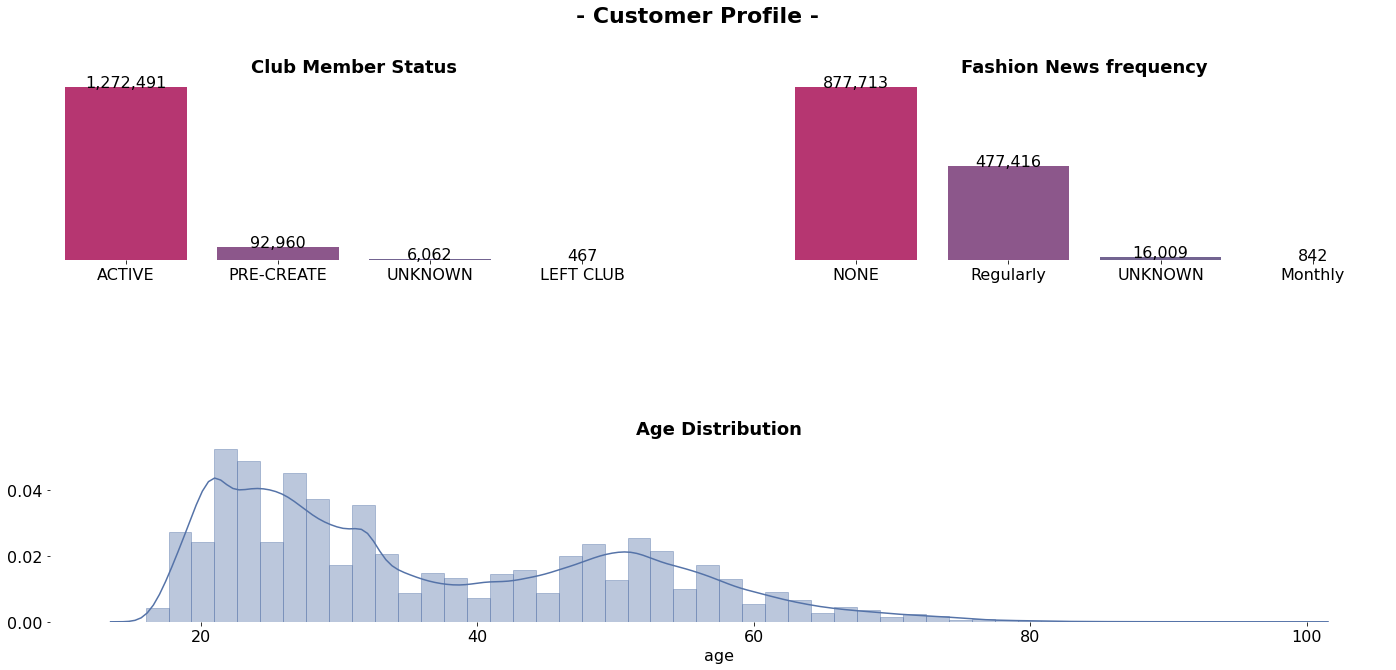

In [62]:
plt.figure(figsize=(24, 10))
plt.suptitle('- Customer Profile -', size=22, weight="bold")

ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)

sns.countplot(data=customers, x="club_member_status", ax=ax1,
              order=customers['club_member_status'].value_counts().index,
              palette=my_colors[2:])
show_values_on_bars(axs=ax1, h_v="v", space=0.4)
ax1.set_title("Club Member Status", size=18, weight="bold")
ax1.set_yticks([])
ax1.set_xlabel("")
ax1.set_ylabel("")

sns.countplot(data=customers, x="fashion_news_frequency", ax=ax2,
              order=customers['fashion_news_frequency'].value_counts().index,
              palette=my_colors[2:])
show_values_on_bars(axs=ax2, h_v="v", space=0.4)
ax2.set_title("Fashion News frequency", size=18, weight="bold")
ax2.set_yticks([])
ax2.set_xlabel("")
ax2.set_ylabel("")

sns.distplot(customers["age"], color=my_colors[-3], ax=ax3,
             hist_kws=dict(edgecolor=my_colors[-3]))
ax3.set_title("Age Distribution", size=18, weight="bold")
ax3.set_ylabel("")

for ax in [ax1, ax2]:
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    # ax.imshow(bk_image, zorder=0, extent=[x0, x1, y0, y1], alpha=0.35, aspect='auto')
    
# insert_image(path='../input/hm-fashion-recommender-dataset/pics/vans.jpg', zoom=0.5, xybox=(60, 0.00), ax=ax3)

sns.despine(left=True, bottom=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.99);

In [63]:
# 🐝 Log Barplot to W&B
dt = customers["club_member_status"].value_counts().reset_index()
create_wandb_plot(x_data= dt["index"], y_data=dt["club_member_status"],
                  x_name="Status", y_name="Frequency", 
                  title="- Club Member Status -", log="member_status", plot="bar")

dt = customers["fashion_news_frequency"].value_counts().reset_index()
create_wandb_plot(x_data= dt["index"], y_data=dt["fashion_news_frequency"],
                  x_name="News", y_name="Frequency", 
                  title="- Fashion News Frequency -", log="news_freq", plot="bar")

create_wandb_hist(x_data=customers["age"], x_name="Age", 
                  title="Age Distribution", log="age_dist")

wandb.finish()

In [64]:
# 🪄🐝 Save the updated `customers` file.
customers.to_parquet('customers.pqt', index=False)

save_dataset_artifact(run_name="save_customers", artifact_name="customers",
                      path="customers.pqt")


Artifact has been saved successfully.


In [65]:
# 🐝 W&B Experiment
run = wandb.init(project='HandM', name='Transactions', config=CONFIG)

In [66]:
print(clr.S+"Missing values within transactions dataset:"+clr.E)
print(transactions.isna().sum())

# 🐝 Log length of transactions
wandb.log({"transaction_ids":len(transactions)})

# Adjust article_id (as did for articles dataframe)
transactions["article_id"] = transactions["article_id"].apply(lambda x: adjust_id(x))

Missing values within transactions dataset:
t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64


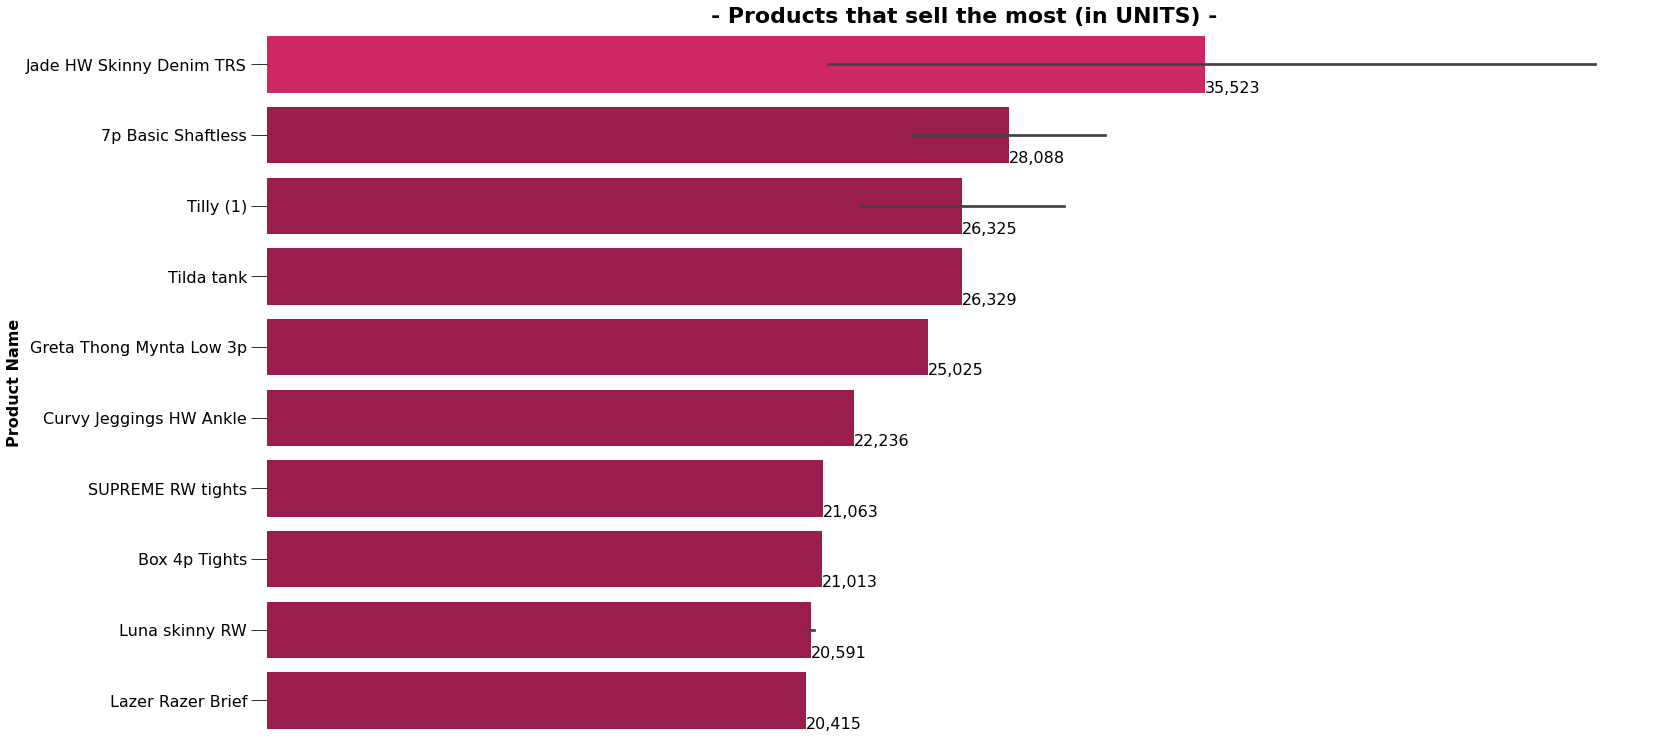

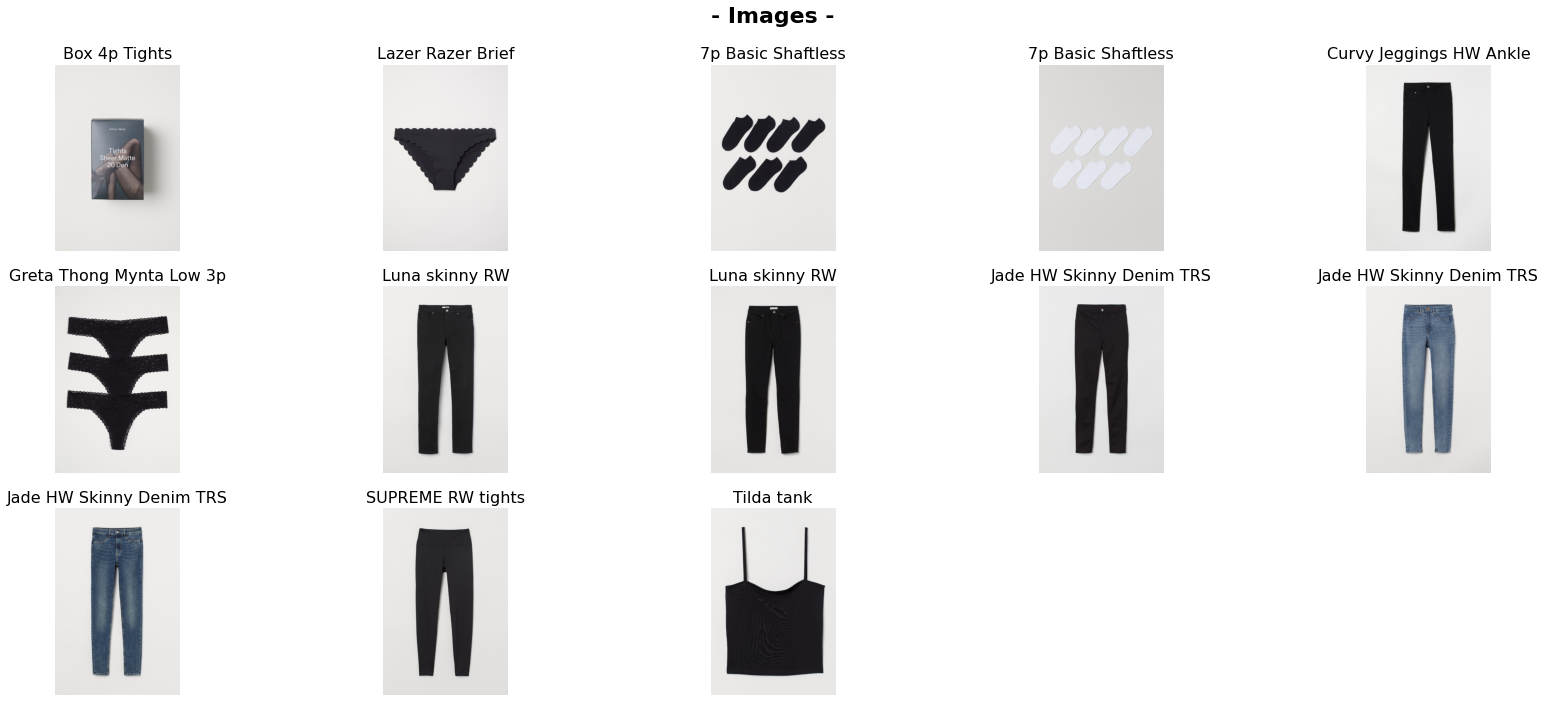

In [67]:
# Get data
top_sold_products = transactions["article_id"].value_counts().reset_index().head(15)
top_sold_products.columns = ["article_id", "count"]
top_sold_products = pd.merge(top_sold_products, articles, on="article_id")[["article_id", "count", "prod_name"]]

clrs = ["#E90B60" if x==max(top_sold_products["count"]) else '#AF0848' for x in top_sold_products["count"]]

# Get images
image_paths = [path for path in articles[articles["article_id"].isin(top_sold_products["article_id"].tolist())]["path"].tolist() 
               if path != None]
image_names = articles[articles["path"].isin(image_paths)]["prod_name"].tolist()


# Plot
fig, ax = plt.subplots(figsize=(25, 13))
plt.title('- Products that sell the most (in UNITS) -', size=22, weight="bold")

sns.barplot(data=top_sold_products, x="count", y="prod_name", ax=ax,
            palette=clrs)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
# plt.imshow(bk_image, zorder=0, extent=[x0, x1, y0, y1], alpha=0.35, aspect='auto')

show_values_on_bars(axs=ax, h_v="h", space=0.4)
plt.ylabel("Product Name", size = 16, weight="bold")
plt.xlabel("")
plt.xticks([])
plt.yticks(size=16)
plt.tick_params(size=16)

# insert_image(path='../input/hm-fashion-recommender-dataset/pics/chloe.jpg', zoom=0.45, xybox=(40000, 14), ax=ax)

sns.despine(left=True, bottom=True)
plt.show();

print("\n")

# Plot
fig, axs = plt.subplots(3, 5, figsize=(23, 10))
fig.suptitle('- Images -', size=22, weight="bold")
axs = axs.flatten()

for k, (path, name) in enumerate(zip(image_paths, image_names)):
    axs[k].set_title(f"{name}", size = 16)
    img = plt.imread(path)
    axs[k].imshow(img)
    axs[k].axis("off")

for a in [-1, -2]: axs[a].set_visible(False)
plt.tight_layout()
plt.show()

In [68]:
# 🐝 Log Barplot to W&B
create_wandb_plot(x_data= top_sold_products["prod_name"], y_data=top_sold_products["count"],
                  x_name="Prod Name", y_name="Count", 
                  title="- Products that sell the most (UNITS) -", log="sold_most", plot="bar")

Maximum Price is: 0.5915254237288136 
Minimum Price is: 1.694915254237288e-05 
Average Price is: 0.027829273856993582


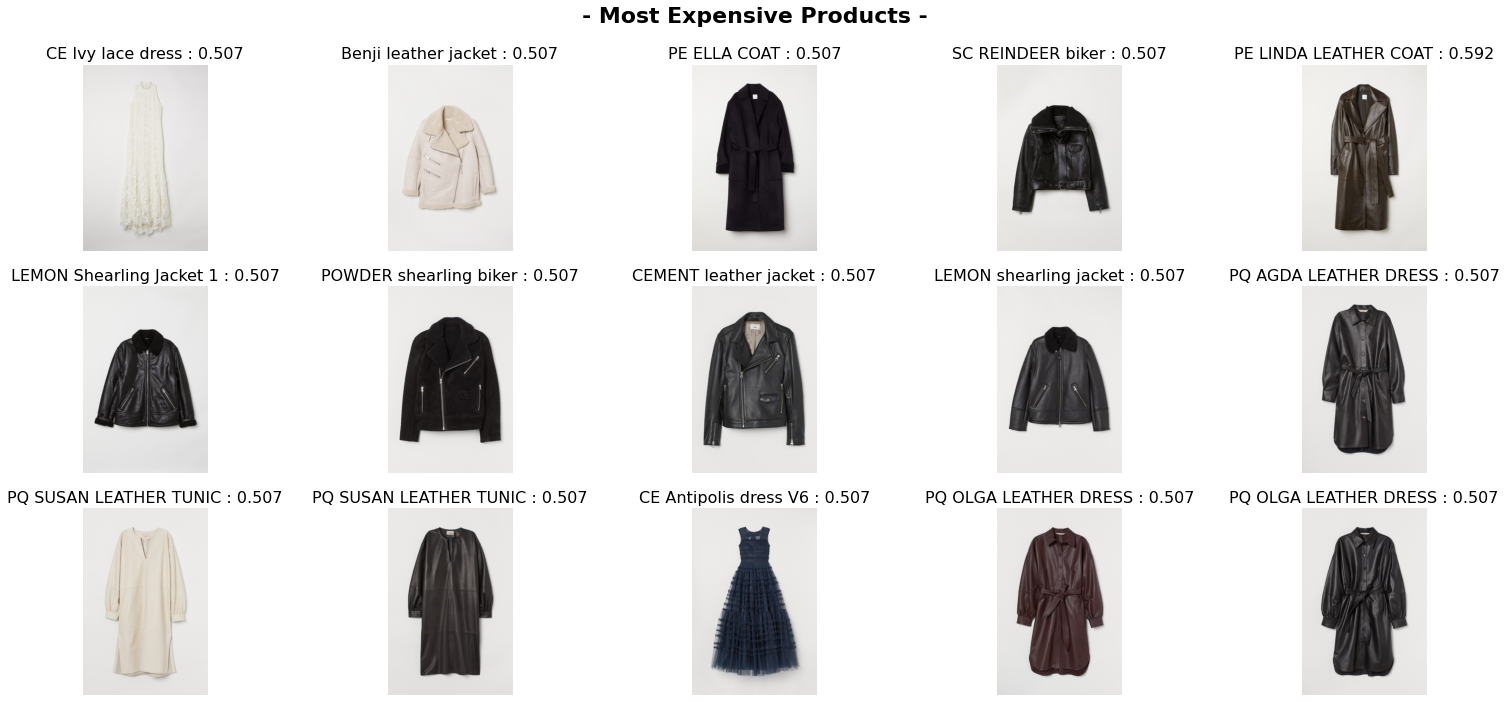

In [69]:
print(clr.S+"Maximum Price is:"+clr.E, transactions["price"].max(), "\n" +
      clr.S+"Minimum Price is:"+clr.E, transactions["price"].min(), "\n" +
      clr.S+"Average Price is:"+clr.E, transactions["price"].mean())

# Get data
top_sold_products = transactions.groupby("article_id")["price"].max().reset_index()\
                                        .sort_values("price", ascending=False).head(15)
top_sold_products.columns = ["article_id", "price"]
top_sold_products = pd.merge(top_sold_products, articles, on="article_id")[["article_id", "price", "prod_name"]]

clrs = ["#E90B60" if x==max(top_sold_products["price"]) else '#AF0848' for x in top_sold_products["price"]]

# Get images
image_paths = [path for path in articles[articles["article_id"].isin(top_sold_products["article_id"].tolist())]["path"].tolist() 
               if path != None]
image_names = articles[articles["path"].isin(image_paths)]["prod_name"].tolist()

# Plot
fig, axs = plt.subplots(3, 5, figsize=(23, 10))
fig.suptitle('- Most Expensive Products -', size=22, weight="bold")
axs = axs.flatten()

for k, (path, name) in enumerate(zip(image_paths, image_names)):
    prc = top_sold_products[top_sold_products["prod_name"]==name]["price"].values[0]
    axs[k].set_title(f"{name} : {round(prc, 3)}", size = 16)
    img = plt.imread(path)
    axs[k].imshow(img)
    axs[k].axis("off")

# for a in [-1, -2]: axs[a].set_visible(False)
plt.tight_layout()
plt.show()

=== UNITS/ORDER ===
Maximum Units/Order is: 1895 
Minimum Units/Order is: 1 
Average Units/Order is: 23.334630667241193 

=== SPENDING/ORDER ===
Maximum Spending/Order is: 57.67640677966092 
Minimum Spending/Order is: 0.0007627118644067 
Average Spending/Order is: 0.6493858271904589


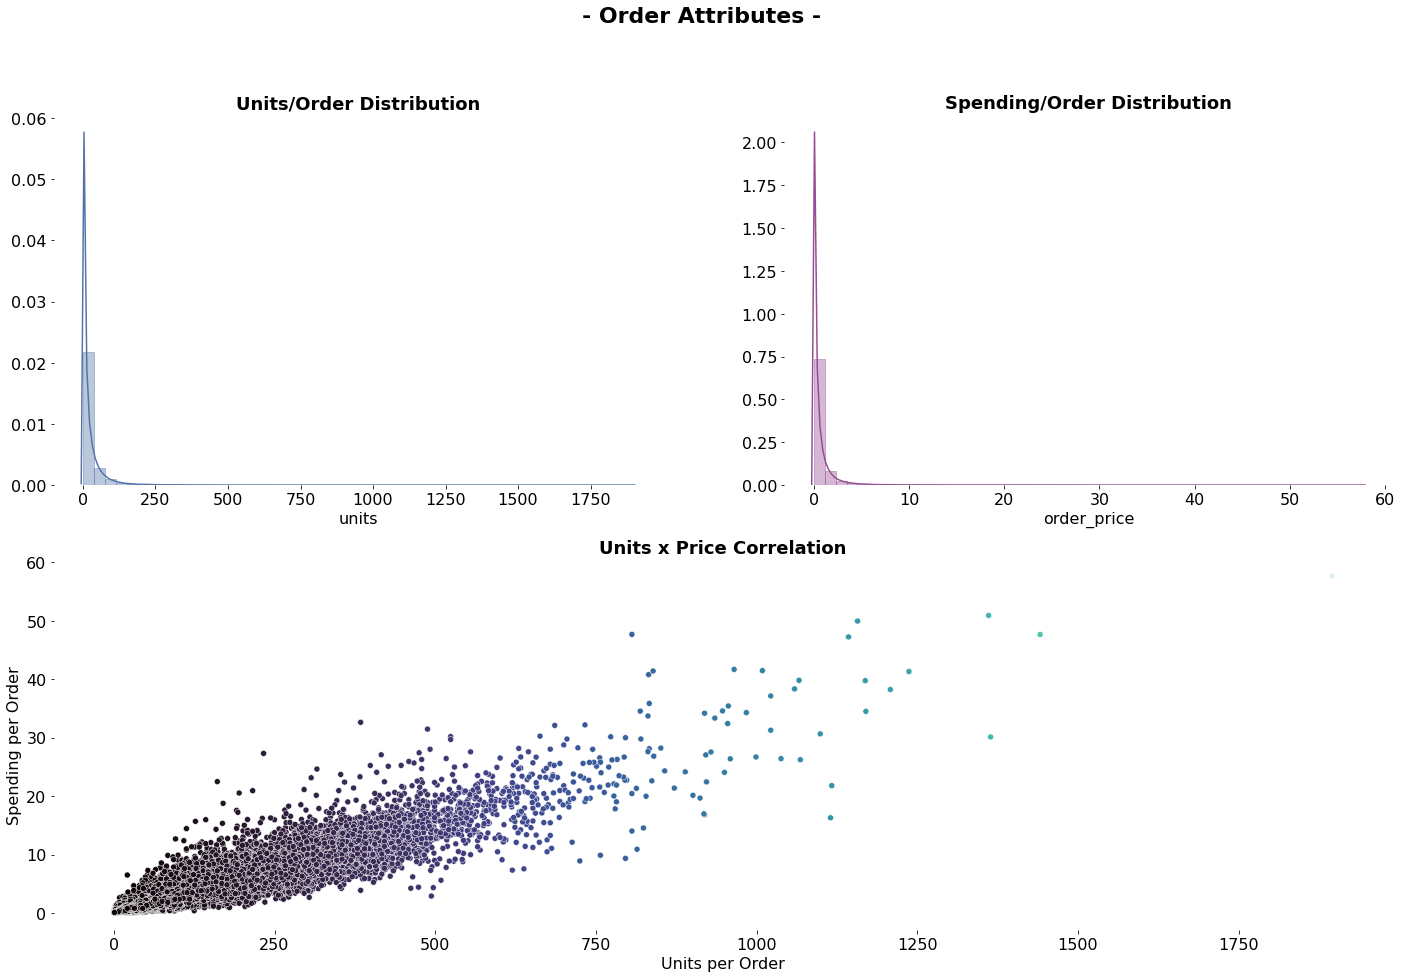

In [70]:
# Data
basket = transactions.groupby("customer_id").agg({'article_id':'count', 
                                                  'price': 'sum'}).reset_index()
basket.columns = ["customer_id", "units", "order_price"]

print(clr.S+"=== UNITS/ORDER ==="+clr.E)
print(clr.S+"Maximum Units/Order is:"+clr.E, basket["units"].max(), "\n" +
      clr.S+"Minimum Units/Order is:"+clr.E, basket["units"].min(), "\n" +
      clr.S+"Average Units/Order is:"+clr.E, basket["units"].mean(), "\n")

print(clr.S+"=== SPENDING/ORDER ==="+clr.E)
print(clr.S+"Maximum Spending/Order is:"+clr.E, basket["order_price"].max(), "\n" +
      clr.S+"Minimum Spending/Order is:"+clr.E, basket["order_price"].min(), "\n" +
      clr.S+"Average Spending/Order is:"+clr.E, basket["order_price"].mean())

# Plot
plt.figure(figsize=(24, 15))
plt.suptitle('- Order Attributes -', size=22, weight="bold")

ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)

sns.distplot(basket["units"], color=my_colors[-3], ax=ax1,
             hist_kws=dict(edgecolor=my_colors[-3]))
ax1.set_title("Units/Order Distribution", size=18, weight="bold")
ax1.set_ylabel("")

sns.distplot(basket["order_price"], color=my_colors[-5], ax=ax2,
             hist_kws=dict(edgecolor=my_colors[-5]))
ax2.set_title("Spending/Order Distribution", size=18, weight="bold")
ax2.set_ylabel("")

sns.scatterplot(data=basket, x="units", y="order_price", hue="units", palette="mako", 
                legend=None, ax=ax3)
ax3.set_title("Units x Price Correlation", size=18, weight="bold")
ax3.set_ylabel("Spending per Order")
ax3.set_xlabel("Units per Order")

sns.despine(left=True, bottom=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None);

In [71]:
# 🐝 Log parameters
wandb.log({"average_units_per_order" : basket["units"].mean(),
           "average_spending_per_order" : basket["order_price"].mean()})

wandb.finish()

In [72]:
# 🐝 Save the updated `transactions` file.
transactions.to_parquet('transactions.pqt', index=False)

save_dataset_artifact(run_name="save_transactions", artifact_name="transactions",
                      path="transactions.pqt")


Artifact has been saved successfully.


In [73]:
del articles, customers, transactions, ss
del top_sold_products, prod_appearance, prod_color, prod_name
gc.collect()

94441